# Gradient-boosted regression on unsmoothed data

In [1]:
import xgboost as xgb

import pandas as pd                                                                                                                                         
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import pickle
import copy

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.facecolor'] = 'white'
import seaborn as sns

from sklearn.metrics import r2_score

read train, validation, and test data from previously pickled file

In [2]:
with open('ensemble_data.pickle') as f:
    data = pickle.load(f)

df_train = data['xtrain']
df_val = data['xval']
df_test = data['xtest']

y_train = data['ytrain']
y_val = data['yval']
y_test = data['ytest']

Set missing values, since xgBoost can actually handle these

In [3]:
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

missing_val = -99999

cols = ['min_solvetime', 'max_solvetime',
        'mean_solvetime', 'tot_solvetime',
        'mean_timediff', 'max_timediff',
        'min_timediff']
for c in cols:
    nanidx = df_train[c] < 0
    df_train.loc[nanidx, c] = -99999
    nanidx = df_test[c] < 0
    df_test.loc[nanidx, c] = -99999
    nanidx = df_val[c] < 0
    df_val.loc[nanidx, c] = -99999

In [4]:
df_trainval = pd.concat([df_train, df_val])
y_trainval = pd.concat([y_train, y_val])

In [5]:
xgmat = xgb.DMatrix( df_train, label=y_train, missing = missing_val)
xgmat_test = xgb.DMatrix( df_test, label=y_test, missing = missing_val)
xgmat_val = xgb.DMatrix( df_val, label=y_val, missing = missing_val)
xgmat_trainval = xgb.DMatrix( df_trainval, label=y_trainval, missing = missing_val)

## grid search
use own gridsearch since sklearn wrapper seems to be super slow--there's probably a bug in the implementation
setup parameters for xgboost, don't need to parallelize for now since performance seems ok


In [100]:
# from first run with:
# max_depth = [10, 20, 50]
# gamma = [50, 500, 5000]
# min_ch = [0, 10, 100, 1000]
# ----> mcw looks best between 100 and 1000
# ----> max_depth looks too low at 10
# ----> system appears to be insensitive to gamma
param = {}
param['objective'] = 'reg:linear'
param['eval_metric'] = 'rmse'

max_depth = [20, 50, 100]
gamma = [50000]
min_ch = [10, 50, 100, 200, 300]

grid = []
for md in max_depth:
    for g in gamma:
        for mc in min_ch:
            # -------------------------------
            # model complexity
            param['max_depth'] = md
            param['gamma'] = g
            param['min_child_weight'] = mc
            
            print param
            
            bst = xgb.train( param, xgmat)
            
            grid_item = dict(
                max_depth=md,
                gamma=g,
                min_child_weight=mc,
                train_r2=r2_score(y_train, bst.predict(xgmat)),
                cv_r2=r2_score(y_val, bst.predict(xgmat_val))
            )
            
            grid.append(grid_item)
            print grid_item

{'objective': 'reg:linear', 'gamma': 50000, 'max_depth': 20, 'eval_metric': 'rmse', 'min_child_weight': 10}
{'max_depth': 20, 'cv_r2': 0.46799062269025637, 'train_r2': 0.55407593868136096, 'gamma': 50000, 'min_child_weight': 10}
{'objective': 'reg:linear', 'gamma': 50000, 'max_depth': 20, 'eval_metric': 'rmse', 'min_child_weight': 50}
{'max_depth': 20, 'cv_r2': 0.44431035329170443, 'train_r2': 0.50282560497293693, 'gamma': 50000, 'min_child_weight': 50}
{'objective': 'reg:linear', 'gamma': 50000, 'max_depth': 20, 'eval_metric': 'rmse', 'min_child_weight': 100}
{'max_depth': 20, 'cv_r2': 0.42696532031465284, 'train_r2': 0.47155759397892227, 'gamma': 50000, 'min_child_weight': 100}
{'objective': 'reg:linear', 'gamma': 50000, 'max_depth': 20, 'eval_metric': 'rmse', 'min_child_weight': 200}
{'max_depth': 20, 'cv_r2': 0.407295596349599, 'train_r2': 0.43970702257523908, 'gamma': 50000, 'min_child_weight': 200}
{'objective': 'reg:linear', 'gamma': 50000, 'max_depth': 20, 'eval_metric': 'rmse'

In [220]:
r2diff = [g['train_r2'] - g['cv_r2'] for g in grid]
idx = np.argwhere(r2diff == min(r2diff)).squeeze()
print grid[idx]

r2max = [g['cv_r2'] for g in grid]
idx = np.argwhere(r2diff == max(r2diff)).squeeze()
for i in idx:
    print grid[i]

{'max_depth': 20, 'cv_r2': 0.39810056408147876, 'train_r2': 0.42459994073848839, 'gamma': 50000, 'min_child_weight': 300}
{'max_depth': 50, 'cv_r2': 0.4709466885912561, 'train_r2': 0.56151150283164819, 'gamma': 50000, 'min_child_weight': 10}
{'max_depth': 100, 'cv_r2': 0.4709466885912561, 'train_r2': 0.56151150283164819, 'gamma': 50000, 'min_child_weight': 10}


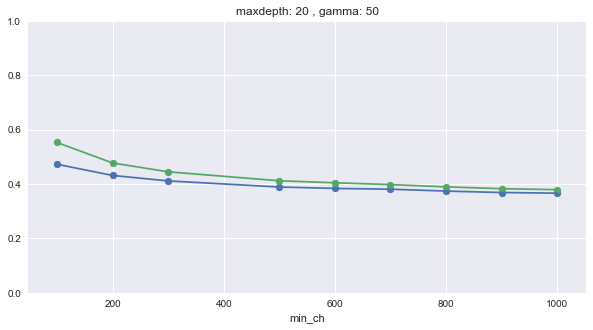

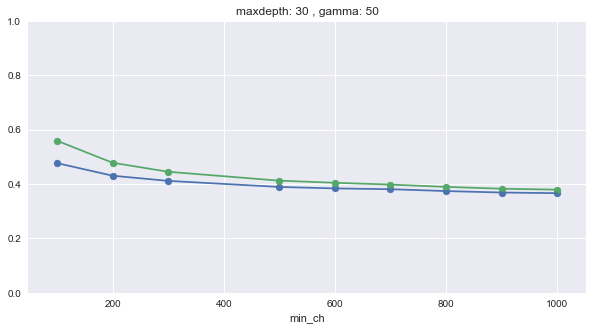

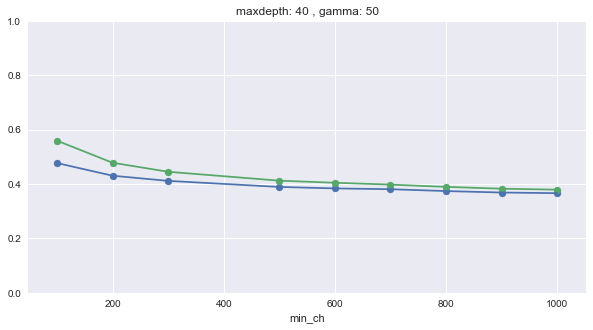

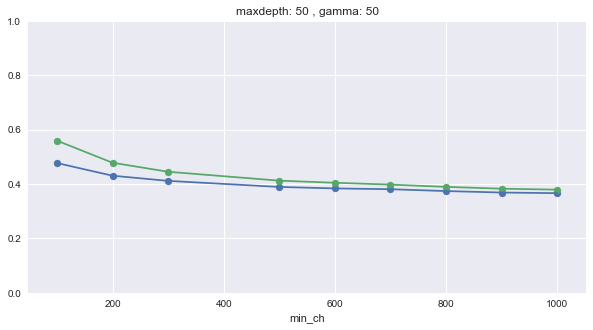

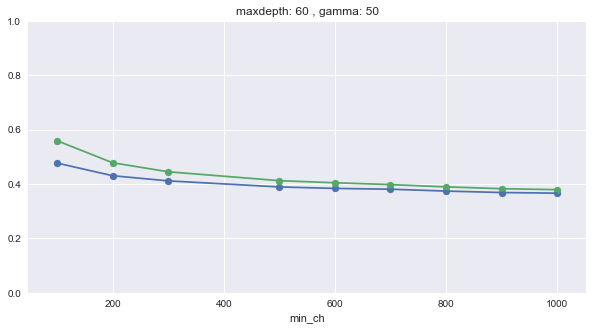

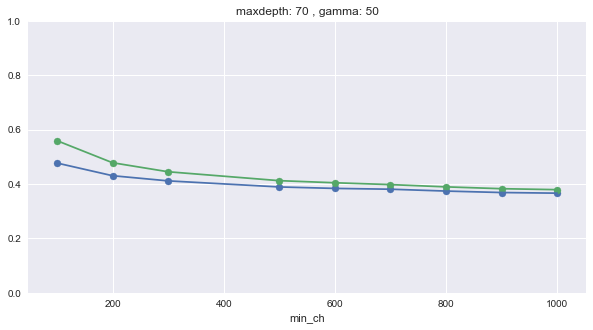

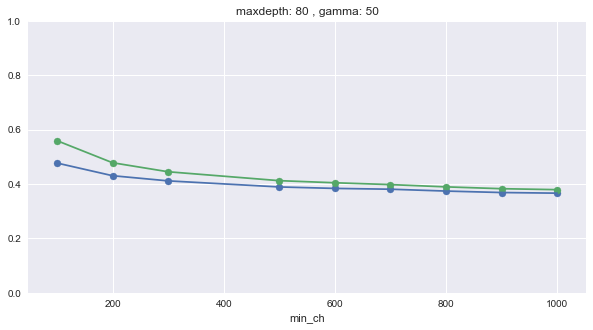

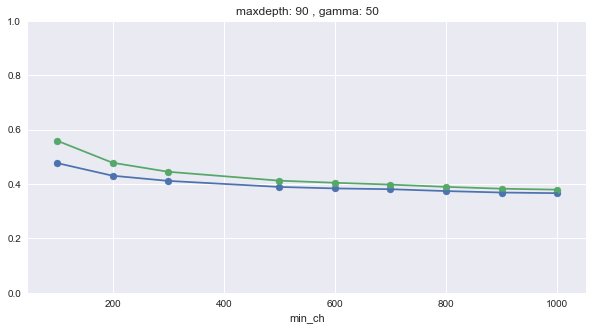

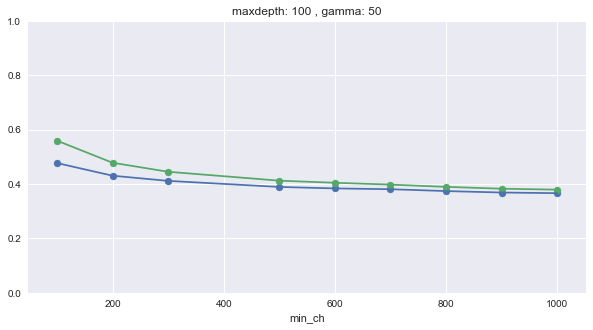

In [31]:
for gm in gamma:
    for md in max_depth:
        r2val = [g['cv_r2'] for g in grid if g['gamma']==gm and g['max_depth'] == md]
        r2train = [g['train_r2'] for g in grid if g['gamma'] == gm and g['max_depth'] == md]

        plt.figure()
        plt.rcParams['figure.figsize'] = (10, 5)
        plt.plot(min_ch, r2val)
        plt.scatter(min_ch, r2val)
        plt.plot(min_ch, r2train)
        plt.xlabel('min_ch')
        plt.scatter(min_ch, r2train)
        plt.ylim(0, 1)
        plt.title(" ".join(map(str, ["maxdepth:", md, ", gamma:", gm])))

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
sns.jointplot(df_train.oldrating, y_train, kind="hex", gridsize=40)

from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('fig_rating_vs_delta.pdf')
plt.savefig(pp, format='pdf')

# Create "lite" versions of the training set for the webapp

In [38]:
drop_features = [ '2-sat', '*special', 'chinese remainder theorem', 'fft', 'n_harder', 'n_harder100', 'n_harder50', 'n_harder500', 'n_unlikely01', 'n_unlikely02' ]
drop_features.extend([c for c in df_train.columns if 'max' in c])
drop_features.extend([c for c in df_train.columns if 'std' in c])
drop_features.extend([c for c in df_train.columns if 'probability' in c])
#drop_features.extend([c for c in df_train.columns if 'smoothed' in c])

In [39]:
df_train_lite = df_train.drop(drop_features, axis=1)
df_test_lite = df_test.drop(drop_features, axis=1)
df_val_lite = df_val.drop(drop_features, axis=1)

In [40]:
xgmat_lite = xgb.DMatrix( df_train_lite, label=y_train, missing = missing_val)
xgmat_test_lite = xgb.DMatrix( df_test_lite, label=y_test, missing = missing_val)
xgmat_val_lite = xgb.DMatrix( df_val_lite, label=y_val, missing = missing_val)

### Save new information to sql

In [62]:
import psycopg2
from sqlalchemy import *

engine = create_engine('postgresql://%s@localhost/%s'%(username,dbname))

dbname = 'codeforces'
username = 'Joy'
con = psycopg2.connect(database = dbname, user = username)
cur = con.cursor()

### handles

In [68]:
xgb_handles=[i[0] for i in df_train_lite.index.values]
xgb_handles.extend([i[0] for i in df_test_lite.index.values])
xgb_handles.extend([i[0] for i in df_val_lite.index.values])
xgb_handles = pd.Series(list(set(xgb_handles)))

In [71]:
# create table with schema
metadata = MetaData()
#index	creationTimeSeconds	id	verdict	ghost	defender	hacker	contestID	problemID	problemName
xgbh = Table('xgb_handles', metadata,
    Column('handle', String, primary_key=True)
)
xgbh.drop(engine, checkfirst=True)
xgbh.create(engine)

xgb_handles.to_sql('xgb_handles', engine, if_exists='replace')

### last entry

In [81]:
df_all = pd.concat([df_train_lite, df_val_lite, df_test_lite])

In [82]:
handles = set([x[0] for x in df_all.index])
df_all.reset_index(inplace=True)

In [83]:
df_all.copy = False
last_ex = []
g = df_all.groupby('handle')
for k, v in g:
    ex = v.sort_index().iloc[-1]
    last_ex.append(pd.DataFrame([ex]))

In [84]:
last_ex = pd.concat(last_ex)

In [90]:
last_ex.to_sql('xgb_last', engine, if_exists='replace', index=False)

In [91]:
con.rollback()
query = """
ALTER TABLE xgb_last ADD PRIMARY KEY (handle);
"""
cur.execute(query)
con.commit()

## Train lite estimator

In [41]:
param = {}
param['objective'] = 'reg:linear'
param['eval_metric'] = 'rmse'
#param['gamma'] = 30
#param['max_depth'] = 200
#param['min_child_weight'] = 1
param['gamma'] = 0
param['max_depth'] = 15
param['min_child_weight'] = 0
param['n_estimators'] = 50

bst = xgb.train( param, xgmat_lite)

Final $r^2$ scores

In [42]:
print r2_score(y_train, bst.predict(xgmat_lite)),
print r2_score(y_val, bst.predict(xgmat_val_lite))
print r2_score(y_test, bst.predict(xgmat_test_lite)),

0.723074777297 0.540682217824
0.412996564057


In [94]:
with open('xgb_lite.pickle', 'w') as f:
    pickle.dump(bst, f)

### testing the pickled model

In [232]:
from eli5 import explain_prediction_xgboost
from eli5 import explain_weights_xgboost

In [95]:
with open('webapp/models/xgb_lite.pickle') as f:
    model = pickle.load(f)

In [157]:
q = """ 
select tag from all_tags
"""
all_tags = pd.read_sql(q, con)['tag']
all_tags = set(all_tags)

all_tags.discard("2-sat")
all_tags.discard("fft")
all_tags.discard("*special")
all_tags.discard("chinese remainder theorem")

In [266]:
hdl = 'yj12'
xgb_x_df = pd.read_sql("select * from xgb_last where handle='%s'" % hdl, con).drop(['handle', 'contestid'], axis=1)
xgb_x = xgb.DMatrix(xgb_x_df, missing=missing_val)

orig = model.predict(xgb_x)[0]

### Evaluating feature importance

The really fascinating thing about this way of looking at feature importances is that it is **much more consistent** with the RF regressor than the standard feature importance calculations.

In [233]:
explanation = explain_weights_xgboost(model)

In [258]:
ft_names = [x.feature for x in explanation.feature_importances.importances]
ft_vals = [x.weight for x in explanation.feature_importances.importances]
ft_stds = [x.std for x in explanation.feature_importances.importances]

In [247]:
explanation

Weight,Feature
0.1155,n100
0.0760,performance
0.0350,n200
0.0274,total_contests
0.0261,smoothed_5months
0.0252,oldrating
0.0206,n300
0.0204,smoothed_4months
0.0202,smoothed_3months
0.0184,n400


We can also get explanations for specific predictions!

In [267]:
explain_prediction_xgboost(model, xgb_x_df, is_regression=True, feature_names=xgb_x_df.columns.values)

Explanation(estimator='<xgboost.core.Booster object at 0x1438d7c90>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='performance', weight=48.793424338173608, std=None, value=0.057123042787500002), FeatureWeight(feature='mean_ratingdiff_contest', weight=26.886921194073025, std=None, value=30.030303033599999), FeatureWeight(feature='n100', weight=11.977929064600152, std=None, value=2.0), FeatureWeight(feature='min_timediff', weight=10.979243521126762, std=None, value=-99999.0), FeatureWeight(feature='n200', weight=6.164082671699326, std=None, value=2.0), FeatureWeight(feature='total_contests', weight=5.7266231994133525, std=None, value=17.0), FeatureWeight(feature='n_wrong_mean', weight=4.9618210026401686, std=None, value=2.36363636364), FeatureWeight(feature='strings', weight=4.3748367867440621, std=None, value=0.0), FeatureWeight(feature='mean_ratingdiff_practice', weight=3.8896738426687167, std=None, value=225.66666667000001), FeatureWeight(feature='data structures', weight=2.9913521186440661, std=None, value=0.0), FeatureWeight(feature='smoothed_4months', weight=1.6984587449954809, std=None, value=1429.8), FeatureWeight(feature='smoothed_3months', weight=1.6295998012510384, std=None, value=1397.33333333), FeatureWeight(feature='smoothed_5months', weight=1.3812535801072408, std=None, value=1429.8), FeatureWeight(feature='total_error_practice', weight=1.1423369677813007, std=None, value=1.0), FeatureWeight(feature='problems_solved', weight=1.1388871199999997, std=None, value=7.0), FeatureWeight(feature='total_newtags', weight=1.1189266687957886, std=None, value=0.0), FeatureWeight(feature='mean_solvetime', weight=0.89981270444269246, std=None, value=0.34793650793699998), FeatureWeight(feature='graph matchings', weight=0.60882257015261487, std=None, value=0.0), FeatureWeight(feature='<BIAS>', weight=0.56623870692912193, std=None, value=1.0), FeatureWeight(feature='n_solved', weight=0.26628510177930514, std=None, value=10.0)], neg=[FeatureWeight(feature='rating_diff_mean', weight=-29.825549087792993, std=None, value=257.61688311699999), FeatureWeight(feature='mean_timediff', weight=-19.379368786729785, std=None, value=1.2107149216499999), FeatureWeight(feature='mean_wrong_contest', weight=-10.652877396120735, std=None, value=1.5454545454499999), FeatureWeight(feature='number theory', weight=-5.4400503417721531, std=None, value=0.0), FeatureWeight(feature='tot_solvetime', weight=-4.6344731985580978, std=None, value=4.8711111111100003), FeatureWeight(feature='java', weight=-3.0253699999999988, std=None, value=0.0), FeatureWeight(feature='smoothed_1months', weight=-2.8984604181032601, std=None, value=1401.5), FeatureWeight(feature='time_between_mean', weight=-2.7772696916271333, std=None, value=346580.83333300002), FeatureWeight(feature=

Looking at feature importances

/usr/local/lib/python2.7/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


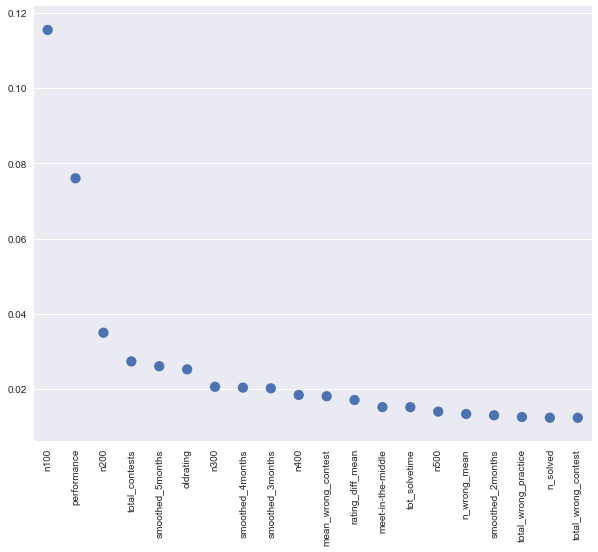

In [265]:
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['figure.figsize'] = (10, 8)

sns.pointplot(ft_names, ft_vals, join=False)
ax = plt.gca()
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
pp = PdfPages('fig_feature_importance_paths_xgb.pdf')
pp.savefig()
pp.close()

## Contribution of problem tags

In [219]:
good_tags = []
bad_tags = []
for t in list(all_tags):
    e = xgb_x_df.copy()
    e[t] += 10
    delta = model.predict(xgb.DMatrix(e))[0] - orig
    if  delta > 0:
        good_tags.append((t, delta))
    elif delta < 0:
        bad_tags.append((t, delta))

good_tags.sort(key=lambda x: x[1], reverse=True)
bad_tags.sort(key=lambda x: x[1], reverse=True)

In [225]:
difficulties = ['n100', 'n200', 'n300', 'n400', 'n500']
e = xgb_x_df.copy()
e['n_solved'] += 10
e['total_problems'] += 10

best_val = -float("Inf")
best_diff = ''
for t in difficulties:
    e[t] += 10
    delta = model.predict(xgb.DMatrix(e))[0] - orig
    if delta > best_val:
        best_val = delta
        best_diff = t
print best_diff, best_val

n500 -1.86019


## Feature importance (built-in functions)

here we see that the built-in feature importance doesn't quite make sense. Why is the usage of java so high? We see from the eli5 package that in terms of actual rating changes, past performance and practice are actually much more important.

In [56]:
imp = pd.Series(bst.get_score())

In [57]:
imp.sort_values(ascending=False)

java                        30051
mean_ratingdiff_contest     10103
mean_error_contest           7764
mean_ratingdiff_practice     6419
mean_timediff                6414
oldrating                    5849
mean_error_practice          4587
mean_solvetime               4556
performance                  4386
mean_wrong_contest           4171
rating_diff_mean             4136
total_problems               3083
n_wrong_mean                 2855
mean_wrong_practice          2760
min_timediff                 2730
smoothed_1months             2572
total_contests               2545
time_between_mean            2442
smoothed_2months             2171
smoothed_3months             2139
n_solved                     2121
smoothed_5months             2026
tot_solvetime                1820
smoothed_4months             1803
total_wrong_contest          1798
unique_tags_total            1654
n_contest                    1479
total_wrong_practice         1379
n100                         1241
problems_solve

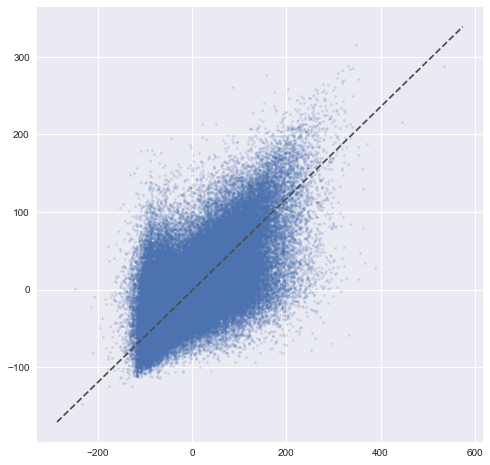

In [60]:
plt.rcParams['figure.figsize'] = (8, 8)
y_test_pred = bst.predict(xgmat_test_lite)
plt.scatter(y_test, y_test_pred, s=5, alpha=.2)
ax=plt.gca()
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

In [243]:
print sum(np.logical_and(y_test_pred > 0, y_test < 0))
print sum(np.logical_and(y_test_pred < 0, y_test > 0))
print sum(np.logical_and(y_test_pred > 0, y_test > 0))
print sum(np.logical_and(y_test_pred < 0, y_test < 0))

17798
16472
48977
62299


In [264]:
import psycopg2
con = psycopg2.connect(database='codeforces', user="Joy")
q = """ 
select tag from all_tags
"""
all_tags = pd.read_sql(q, con)['tag']
all_tags = set(all_tags)


In [89]:
qbin = np.logical_and(df_val.oldrating <= 3700, df_val.oldrating >= 2200)
df_val_bin = df_val.loc[qbin]
y_val_bin = y_val[qbin]
r2_score(y_val_bin, bst.predict(xgb.DMatrix(df_val_bin)))

0.45210935220627724

In [211]:
# setup parameters for xgboost
param = {}
param['objective'] = 'reg:linear'
param['eval_metric'] = 'rmse'

# -------------------------------
# model complexity
param['max_depth'] = 50
param['gamma'] = 5000  #minimum loss reduction required to make a further partition on a leaf node of the tree
param['min_child_weight'] = 100

print param
evals = [(xgmat_val, "test")]
bst = xgb.cv( param, xgmat, num_boost_round=50)

{'objective': 'reg:linear', 'gamma': 5000, 'max_depth': 50, 'eval_metric': 'rmse', 'min_child_weight': 100}


(0, 100)

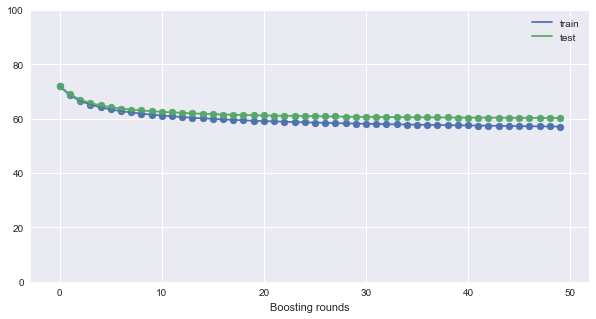

In [186]:
#bst = xgb.cv( param, xgmat, num_boost_round=10)
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(bst['train-rmse-mean'])
plt.scatter(range(len(bst)), bst['train-rmse-mean'])
plt.plot(bst['test-rmse-mean'])
plt.scatter(range(len(bst)), bst['test-rmse-mean'])
plt.legend(['train', 'test'])
plt.xlabel('Boosting rounds')
plt.ylim((0, 100))

In [200]:
model = xgb.train( param, xgmat, evals=evals, early_stopping_rounds=50)


[0]	test-rmse:72.1394
Will train until test-rmse hasn't improved in 50 rounds.
[1]	test-rmse:68.7709
[2]	test-rmse:66.7023
[3]	test-rmse:65.3877
[4]	test-rmse:64.3818
[5]	test-rmse:63.6917
[6]	test-rmse:63.0899
[7]	test-rmse:62.6391
[8]	test-rmse:62.2856
[9]	test-rmse:61.9223


In [203]:
print r2_score(y_train, model.predict(xgmat))
print r2_score(y_val, model.predict(xgmat_val))

0.37792023464
0.366521749203


In [126]:
r2_score(y_test, bst.predict(xgmat_test))

0.40823190149638522

In [132]:
bst.save_model('gradient_boosted_regressor.model')

In [133]:
temp = xgb.Booster({'nthread':4}) #init model
temp.load_model("gradient_boosted_regressor.model") # load data


# sklearn api
Note there appears to be some bug in the API where training takes extremely long

In [31]:
from xgboost import XGBRegressor

In [49]:
model = XGBRegressor(missing=missing_val, **param)

In [ ]:
model.fit(df_train, y_train)

In [ ]:
print model.score(df_train, y_train)
print model.score(df_val, y_val)

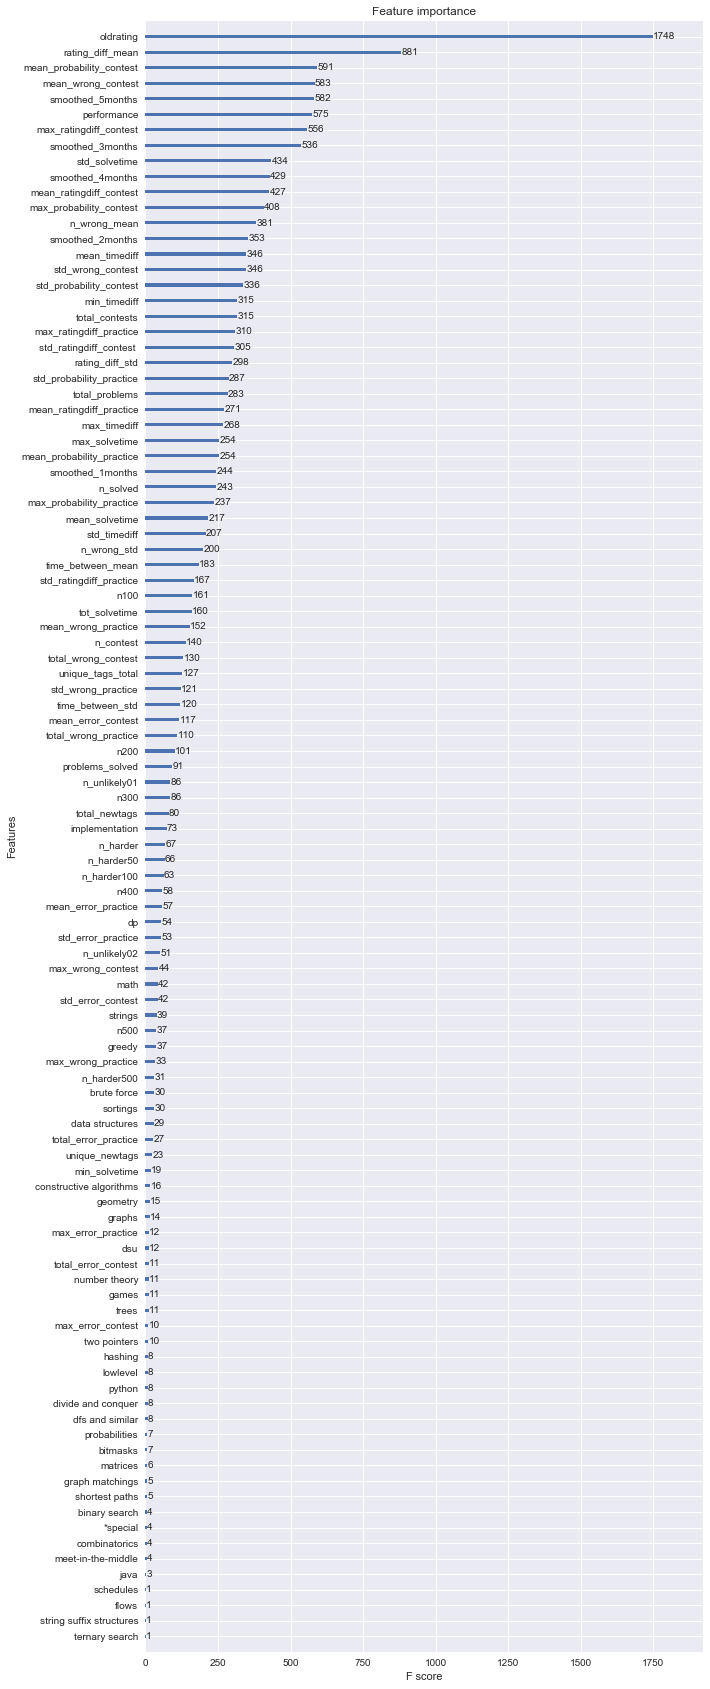

In [118]:
plt.rcParams['figure.figsize'] = (10, 30)
xgb.plot_importance(bst)